# ***Deep Learning - Assignment 4***

Student name - Leor Ariel Rose, ID - 208373365

Student name - Aviv Rovshitz, ID - 307974162

### ***Import packages***

Let's begin with importing all necessary packages:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import (
    Model, Sequential, layers ,optimizers, losses, metrics
)
from scipy.io import arff
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from pandas_profiling import ProfileReport
from typing import Tuple, Dict

### ***Constant definitions***

Next, let's define some constant variables:

In [2]:
# Define the path containing the Data (german_credit.arff, diabetes.arff)
DATA_PATH = "./Data"

# Define the path containing the diabetes data
DIABETES_PATH = f"{DATA_PATH}/diabetes.arff"

# Define the path containing the german credit data
GERMAN_CREDIT_PATH = f"{DATA_PATH}/german_credit.arff"

# Define normalizers for datasets
DIABETES_SCALER = MinMaxScaler()
GERMAN_CREDIT_SCALER = MinMaxScaler()

# Define encoders for datasets
DIABETES_ENC = OneHotEncoder(handle_unknown='ignore', sparse=False)
GERMAN_CREDIT_ENC = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Define batch size
BATCH_SIZE = 32

# Define learning rate
LEARNING_RATE = 0.0003

# Define number of epochs
NUM_EPOCHS = 3000

### ***Auxiliary methods***

Next, let's define some auxiliary methods:

In [3]:
def read_arff(file_path: str) -> pd.DataFrame:
  """Method to read arff file as data frame.

  Args:
    file_path (str): Path to arff file.

  Returns:
    pd.DataFrame: Read data.

  """
  # Load arff data
  data, meta = arff.loadarff(file_path)
  # Create data frame from data and column names
  arff_df = pd.DataFrame(data, columns=meta.names())
  # Decode byte objects to strings
  for n, t in zip(meta.names(), meta.types()):
    if t == "nominal":
      arff_df[n] = arff_df[n].str.decode("utf-8")
  return arff_df


def pre_process_diabetes(diabetes_df: pd.DataFrame) -> pd.DataFrame:
  """Method to preprocess the diabetes data frame.

  Args:
    diabetes_df (pd.DataFrame): Diabetes data frame.

  Returns:
    pd.DataFrame: Clean diabetes data frame.

  """
  # Copy to not change the original
  diabetes_df = diabetes_df.copy()

  # Normalize numeric columns
  diabetes_df.loc[:, diabetes_df.columns != "class"] = (
      DIABETES_SCALER.fit_transform(
          diabetes_df.loc[:, diabetes_df.columns != "class"]
      )
  )

  # Convert all float64 to float32
  cols = diabetes_df.select_dtypes(include=[np.float64]).columns
  diabetes_df[cols] = diabetes_df[cols].astype(np.float32)

  # One hot encoding of the categorical variable
  DIABETES_ENC.fit(diabetes_df[["class"]])
  diabetes_df.loc[:, DIABETES_ENC.get_feature_names_out(
  )] = DIABETES_ENC.fit_transform(diabetes_df[["class"]])
  diabetes_df.drop("class", axis=1, inplace=True)

  return diabetes_df


def inverse_pre_process_diabetes(
    clean_diabetes_df: pd.DataFrame
) -> pd.DataFrame:
  """Method to inverse preprocess of the diabetes data frame.

  Args:
    clean_diabetes_df (pd.DataFrame): Clean diabetes data frame.

  Returns:
    pd.DataFrame: Diabetes data frame.

  """
  # Copy to not change the original
  clean_diabetes_df = clean_diabetes_df.copy()

  # de-normalize numeric columns
  clean_diabetes_df.loc[:, "preg":"age"] = (
      DIABETES_SCALER.inverse_transform(
          clean_diabetes_df.loc[:, "preg":"age"]
      )
  )

  # Convert all float64 to float32
  cols = clean_diabetes_df.select_dtypes(include=[np.float32]).columns
  clean_diabetes_df[cols] = clean_diabetes_df[cols].astype(np.float64)

  # One hot encoding of the categorical variable
  clean_diabetes_df["class"] = DIABETES_ENC.inverse_transform(
      clean_diabetes_df.loc[:, DIABETES_ENC.get_feature_names_out()]
  )
  clean_diabetes_df.drop(DIABETES_ENC.get_feature_names_out(), axis=1, inplace=True)

  return clean_diabetes_df


def pre_process_german_credit(g_credit_df: pd.DataFrame) -> pd.DataFrame:
  pass


### ***Exploratory data analysis***

##### ***Diabetes exploratory data analysis***

Let's do some EDA on the diabetes datasets. We begin with reading the diabetes data:

In [4]:
# Read diabetes data
diabetes_df = read_arff(DIABETES_PATH)

In [11]:
# Create EDA report
diabetes_profile = ProfileReport(diabetes_df, title="Diabetes EDA")
# Export EDA report to html file
diabetes_profile.to_file("diabetes_eda.html")
# Show EDA report
diabetes_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Let's create a list for numerical and categorical columns:

In [5]:
diabetes_num_cols = [
    "preg", "plas", "pres", "skin", "insu", "mass", "pedi", "age"
]
diabetes_cat_cols = ["class"]

Next, let's plot each feature distribution:

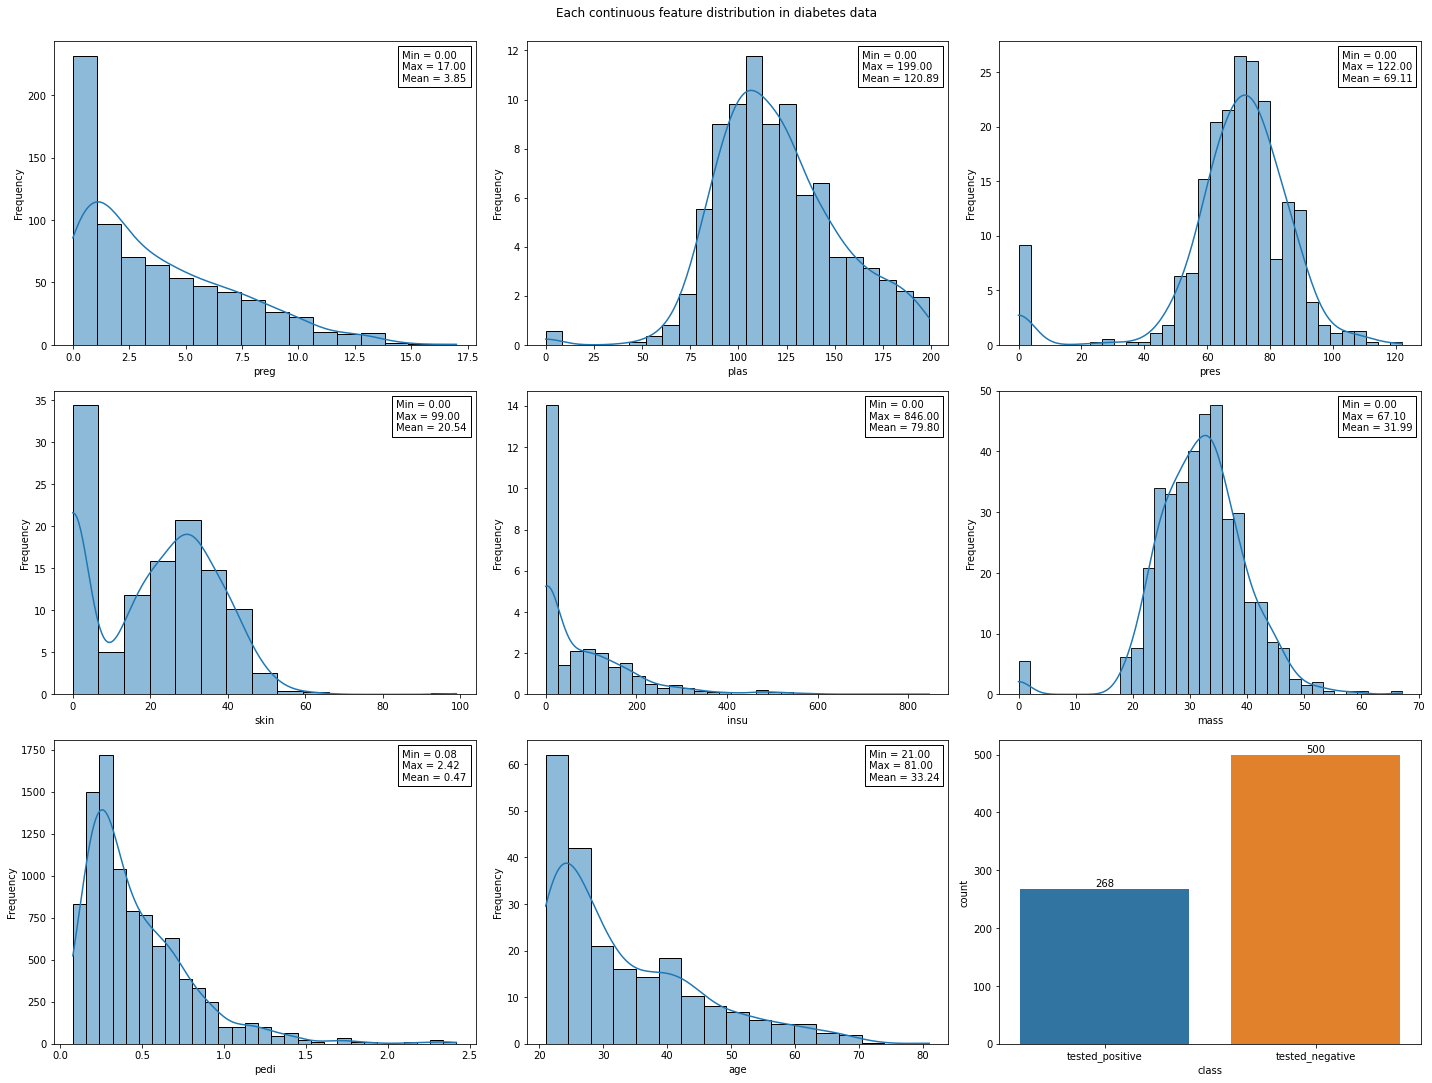

In [6]:
# Create subplots
num_cols = 3
num_rows = round((len(diabetes_num_cols) / num_cols) + 0.5)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))


# Loop over each numeric columns
for col_name, ax in zip(diabetes_num_cols, axes.flat[:len(diabetes_num_cols)]):
  # Get column stats
  col_min = diabetes_df.loc[:, col_name].min()
  col_max = diabetes_df.loc[:, col_name].max()
  col_mean = diabetes_df.loc[:, col_name].mean()
  # Plot histogram of the column
  sns.histplot(data=diabetes_df, x=col_name, kde=True, stat="frequency", ax=ax)
  # Add column stats to plot
  anchored_text = AnchoredText(
      f"Min = {col_min:.2f}\nMax = {col_max:.2f}\nMean = {col_mean:.2f}",
      loc="upper right"
  )
  ax.add_artist(anchored_text)

# Loop over each categorical columns
for col_name, ax in zip(diabetes_cat_cols, axes.flat[len(diabetes_num_cols):]):
  # Plot count plot of the column
  sns.countplot(data=diabetes_df, x=col_name, ax=ax)
  # Add counts to plot
  ax.bar_label(ax.containers[0])

# Add title and show plot
fig.suptitle("Each continuous feature distribution in diabetes data", y=1)
plt.tight_layout()
plt.show()

We can see we need to normalize the features and convert the class to one hot vectors for our model, let's preprocess the data:

In [7]:
clean_diabetes_df = pre_process_diabetes(diabetes_df)

Next, let's create features and class sets:

In [8]:
diabetes_X = clean_diabetes_df.loc[:, "preg":"age"]
diabetes_y = clean_diabetes_df.loc[:, [
    "class_tested_negative", "class_tested_positive"
]]

##### ***German credit exploratory data analysis***

### ***Part 1 – Generative Adversarial Networks***

In this part we will implement a simple GAN model for tabular data.
Let's start with implementing a GAN:

##### ***CGAN implementation***

In [9]:
def make_generator(latent_dim: int, layer_dim: int, data_dim: int) -> Model:
  """Method to create generator for gan.

  Args:
    latent_dim (int): The latent dimension to create noise.
    layer_dim (int): The layer dimension to create generator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Generator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=latent_dim),
          layers.Dense(layer_dim),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Dense(layer_dim),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Dense(layer_dim),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Dense(data_dim, activation="sigmoid")
      ]
  )


def make_discriminator(layer_dim: int, data_dim: int) -> Model:
  """Method to create discriminator for gan.

  Args:
    layer_dim (int): The layer dimension to create discriminator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Discriminator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=data_dim),
          layers.Dense(layer_dim),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(1, activation="sigmoid")
      ]
  )


class CGAN(Model):
  """Conditional GAN class.

  """

  def __init__(self, generator: Model, discriminator: Model, latent_dim: int):
    """Initializer method.

    Args:
      generator (Model): Generator model for CGAN.
      discriminator (Model): Discriminator model for CGAN.
      latent_dim (int): The latent dimension to create noise.

    """
    super(CGAN, self).__init__()

    # Save GAN parameters
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator

    # Create metrics to track generator and discriminator for every batch
    self.g_loss_tracker = metrics.Mean(name="generator_loss")
    self.d_loss_tracker = metrics.Mean(name="discriminator_loss")
    self.d_real_acc_tracker = metrics.Mean(name="discriminator_real_acc")
    self.d_fake_acc_tracker = metrics.Mean(name="discriminator_fake_acc")

  @property
  def metrics(self) -> Tuple[metrics.Mean, ...]:
    """Method to get metrics property.

    Returns:
        Tuple[metrics.Mean, ...]: GAN metrics.

    """
    return (
        self.g_loss_tracker, self.d_loss_tracker, self.d_real_acc_tracker,
        self.d_fake_acc_tracker
    )

  def compile(
      self, d_optimizer: optimizers.Optimizer,
      g_optimizer: optimizers.Optimizer, loss_fn: losses.Loss
  ):
    """Method to Configures the model for training.

    Args:
        d_optimizer (optimizers.Optimizer): Discriminator optimizer.
        g_optimizer (optimizers.Optimizer): Generator optimizer.
        loss_fn (losses.Loss): GAN loss function.

    """
    super(CGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.acc_fn = metrics.BinaryAccuracy()

  def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
    """Method to apply Training process on every batch of data. 

    Args:
        data (Tuple[tf.Tensor, tf.Tensor]): Batch of data.

    Returns:
        Dict[str: float]: Metrics values of training step.

    """
    # Unpack records and labels
    real_records, one_hot_labels = data

    # Cast one hot labels to float32 for compatibility
    one_hot_labels = tf.cast(one_hot_labels, dtype=tf.float32)

    # Sample random points in the latent space for the generator
    # and concatenate the labels.
    random_latent_vectors = tf.random.normal(
        shape=(BATCH_SIZE, self.latent_dim)
    )
    random_vector_labels = tf.concat(
        [random_latent_vectors, one_hot_labels], axis=1
    )

    # Train the discriminator and generator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      # Decode the noise to fake records
      fake_records = self.generator(random_vector_labels)

      # concatenate the labels to fake and real records
      fake_record_and_labels = tf.concat([fake_records, one_hot_labels], axis=1)
      real_record_and_labels = tf.concat([real_records, one_hot_labels], axis=1)

      # Get discriminator prediction on ake and real records
      fake_predictions = self.discriminator(fake_record_and_labels)
      real_predictions = self.discriminator(real_record_and_labels)

      # Calculate fake records loss and metrics
      d_fake_loss = self.loss_fn(tf.zeros((BATCH_SIZE, 1)), fake_predictions)
      d_fake_acc = self.acc_fn(tf.zeros((BATCH_SIZE, 1)), fake_predictions)
      
      # Calculate real records loss and metrics
      d_real_loss = self.loss_fn(tf.ones((BATCH_SIZE, 1)), real_predictions)
      d_real_acc = self.acc_fn(tf.ones((BATCH_SIZE, 1)), real_predictions)
      
      # Calculate discriminator & generator loss
      d_loss = (d_real_loss + d_fake_loss) / 2
      g_loss = self.loss_fn(tf.ones((BATCH_SIZE, 1)), fake_predictions)
    
    # Update discriminator gradients 
    grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    # Update generator gradients 
    grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(grads, self.generator.trainable_weights)
    )

    # Update metrics
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)
    self.d_real_acc_tracker.update_state(d_real_acc)
    self.d_fake_acc_tracker.update_state(d_fake_acc)
    return {
        "g_loss": self.g_loss_tracker.result(),
        "d_loss": self.d_loss_tracker.result(),
        "d_real_acc": self.d_real_acc_tracker.result(),
        "d_fake_acc": self.d_fake_acc_tracker.result()
    }

##### ***Diabetes training & evaluation***

Next, let's train a conditional GAN on the diabetes data:

In [10]:
# Define dimension values
num_class = diabetes_y.shape[-1]
latent_dim = 32
layer_dim = 256
data_dim = diabetes_X.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, layer_dim, data_dim)
dis = make_discriminator(layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn=losses.BinaryCrossentropy()
)

# Train CGAN
history = cgan.fit(diabetes_X, diabetes_y, epochs=NUM_EPOCHS, shuffle=True)

Epoch 1/3000
24/24 [==============================] - 2s 5ms/step - g_loss: 0.7616 - d_loss: 0.6586 - d_real_acc: 0.6305 - d_fake_acc: 0.5428
Epoch 2/3000
24/24 [==============================] - 0s 6ms/step - g_loss: 0.6623 - d_loss: 0.7590 - d_real_acc: 0.6306 - d_fake_acc: 0.6358
Epoch 3/3000
24/24 [==============================] - 0s 5ms/step - g_loss: 0.7314 - d_loss: 0.6642 - d_real_acc: 0.5429 - d_fake_acc: 0.5425
Epoch 4/3000
24/24 [==============================] - 0s 5ms/step - g_loss: 0.6849 - d_loss: 0.5664 - d_real_acc: 0.6171 - d_fake_acc: 0.6150
Epoch 5/3000
24/24 [==============================] - 0s 4ms/step - g_loss: 2.3628 - d_loss: 0.0836 - d_real_acc: 0.6886 - d_fake_acc: 0.6871
Epoch 6/3000
24/24 [==============================] - 0s 5ms/step - g_loss: 2.6424 - d_loss: 0.1609 - d_real_acc: 0.7455 - d_fake_acc: 0.7447
Epoch 7/3000
24/24 [==============================] - 0s 5ms/step - g_loss: 1.4598 - d_loss: 0.6428 - d_real_acc: 0.7671 - d_fake_acc: 0.7674
Epoch 

Next, let's plot training metrics:

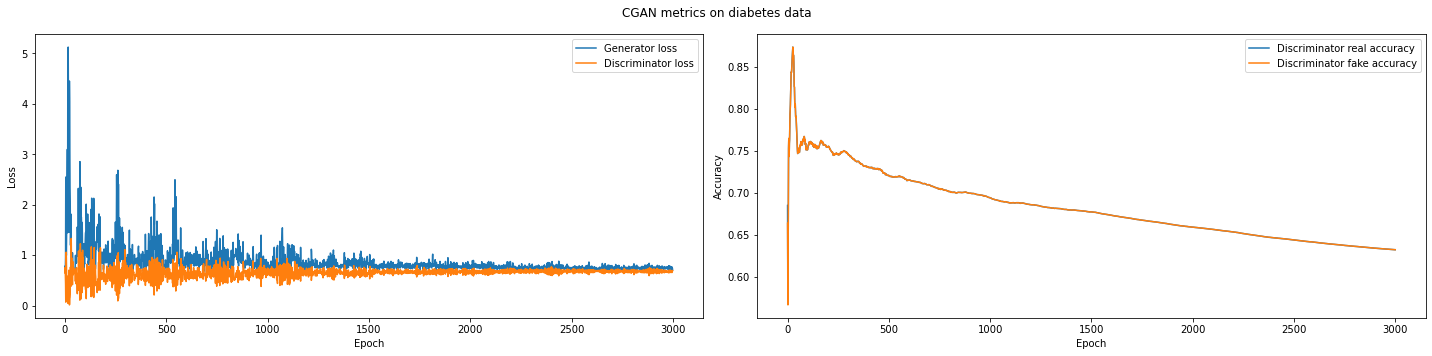

In [11]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [12]:
# Define number of samples to generate
num_samples = 1000

# Get random labels
one_hot_labels = pd.get_dummies(np.random.randint(2, size=num_samples)
                               ).astype(np.float32)

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, one_hot_labels], axis=1)

# Get discriminator predictions
d_fake_predictions = cgan.discriminator.predict(fake_records_and_labels)

# Create a fake diabetes dataframe
fake_clean_diabetes_df = pd.DataFrame(
    fake_records_and_labels, columns=clean_diabetes_df.columns
)

# Inverse preprocess
fake_diabetes_df = inverse_pre_process_diabetes(fake_clean_diabetes_df)

Next, let's plot the probability to be real for the generated samples:

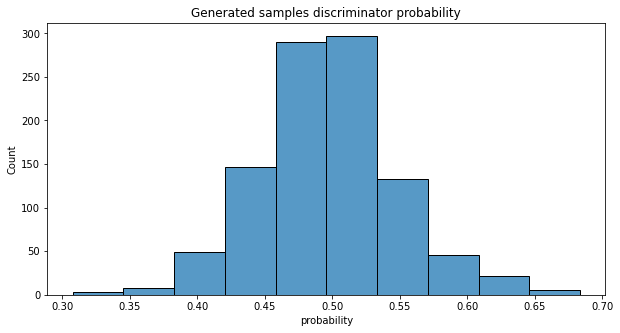

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    pd.DataFrame(d_fake_predictions, columns=["probability"]), x="probability",
    bins=10, ax=ax
)
plt.title("Generated samples discriminator probability")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [14]:
fooled = fake_diabetes_df.iloc[d_fake_predictions > 0.5]
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
fooled.head(10)

Number of sample that did fool the discriminator: 455


,preg,plas,pres,skin,insu,mass,pedi,age,class
0,4.556300,144.486206,70.171768,4.534954e-14,8.212619e-11,25.007036,0.170774,31.476316,tested_positive
4,0.021764,85.820801,70.704269,1.530817e+01,3.331711e+00,19.957523,0.187331,21.273018,tested_negative
5,3.891772,160.158218,84.187721,2.327612e+01,1.119978e+02,29.385572,0.558076,44.920319,tested_positive
6,0.001410,60.244225,78.125008,1.715288e+01,6.170537e-01,20.425831,0.148966,21.086914,tested_negative
7,3.173776,100.190590,61.918736,3.010763e+01,1.809930e+02,31.636980,0.184940,23.110647,tested_negative
9,0.443571,114.172852,85.457611,2.534410e-07,7.578552e-05,27.170479,0.273286,24.752058,tested_negative
11,2.548732,113.162766,59.775883,3.046746e+01,6.234888e+01,32.953873,0.731179,24.408796,tested_positive
12,5.812859,106.182327,66.577065,1.833869e-02,4.653434e-02,27.782696,0.270662,25.008165,tested_positive
14,7.671048,21.513622,92.395798,3.608096e-31,8.674662e-31,21.642979,0.080102,25.530403,tested_negative
16,3.534408,103.055038,70.363815,3.230790e+01,1.477140e+02,33.192944,0.207230,31.888025,tested_positive


In [15]:
not_fooled = fake_diabetes_df.iloc[~(d_fake_predictions > 0.5)]
print(f"Number of sample that did not fool the discriminator: {not_fooled.shape[0]}")
not_fooled.head(10)

Number of sample that did not fool the discriminator: 545


,preg,plas,pres,skin,insu,mass,pedi,age,class
1,5.582403,106.310852,73.837219,3.406186e+01,2.698584e+02,32.621819,0.728012,48.450874,tested_negative
2,5.720425,141.019943,74.292412,1.892530e+01,7.146165e+01,27.616346,1.213633,27.599503,tested_positive
3,0.606451,134.087296,67.534813,1.546887e-32,6.980283e-26,20.955605,0.140510,67.096375,tested_positive
8,0.055510,105.869354,52.997799,3.243527e-04,4.315745e-02,21.351545,0.524013,22.144106,tested_negative
10,4.680428,160.533249,71.204956,3.054382e+01,2.783698e+02,28.951754,0.782536,42.912121,tested_positive
13,9.453055,98.235703,77.335403,9.077760e-05,1.607860e-03,29.618229,0.645494,49.685555,tested_negative
15,5.432950,144.636398,68.545921,3.521671e+01,3.099893e+02,30.641247,0.773401,40.212833,tested_positive
19,1.394026,108.276299,60.644867,1.559424e-16,3.126182e-13,22.290583,0.583392,65.788147,tested_negative
20,4.663211,110.925003,65.693871,2.479147e+01,2.404674e+02,30.179510,0.636575,30.991932,tested_positive
21,6.737392,99.525475,72.028114,3.993733e+01,2.712003e+02,35.160248,0.788332,40.930019,tested_negative


Lets get the distance from 

In [16]:
from table_evaluator import TableEvaluator

In [17]:
diabetes_df

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,tested_negative
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,tested_negative
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,tested_negative
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,tested_positive


In [18]:
fake_diabetes_df.dtypes

preg     float64
plas     float64
pres     float64
skin     float64
insu     float64
mass     float64
pedi     float64
age      float64
class     object
dtype: object

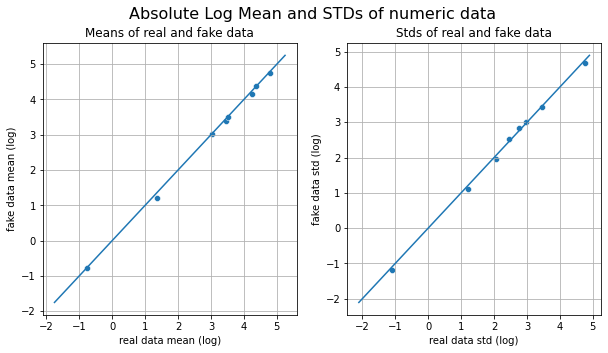

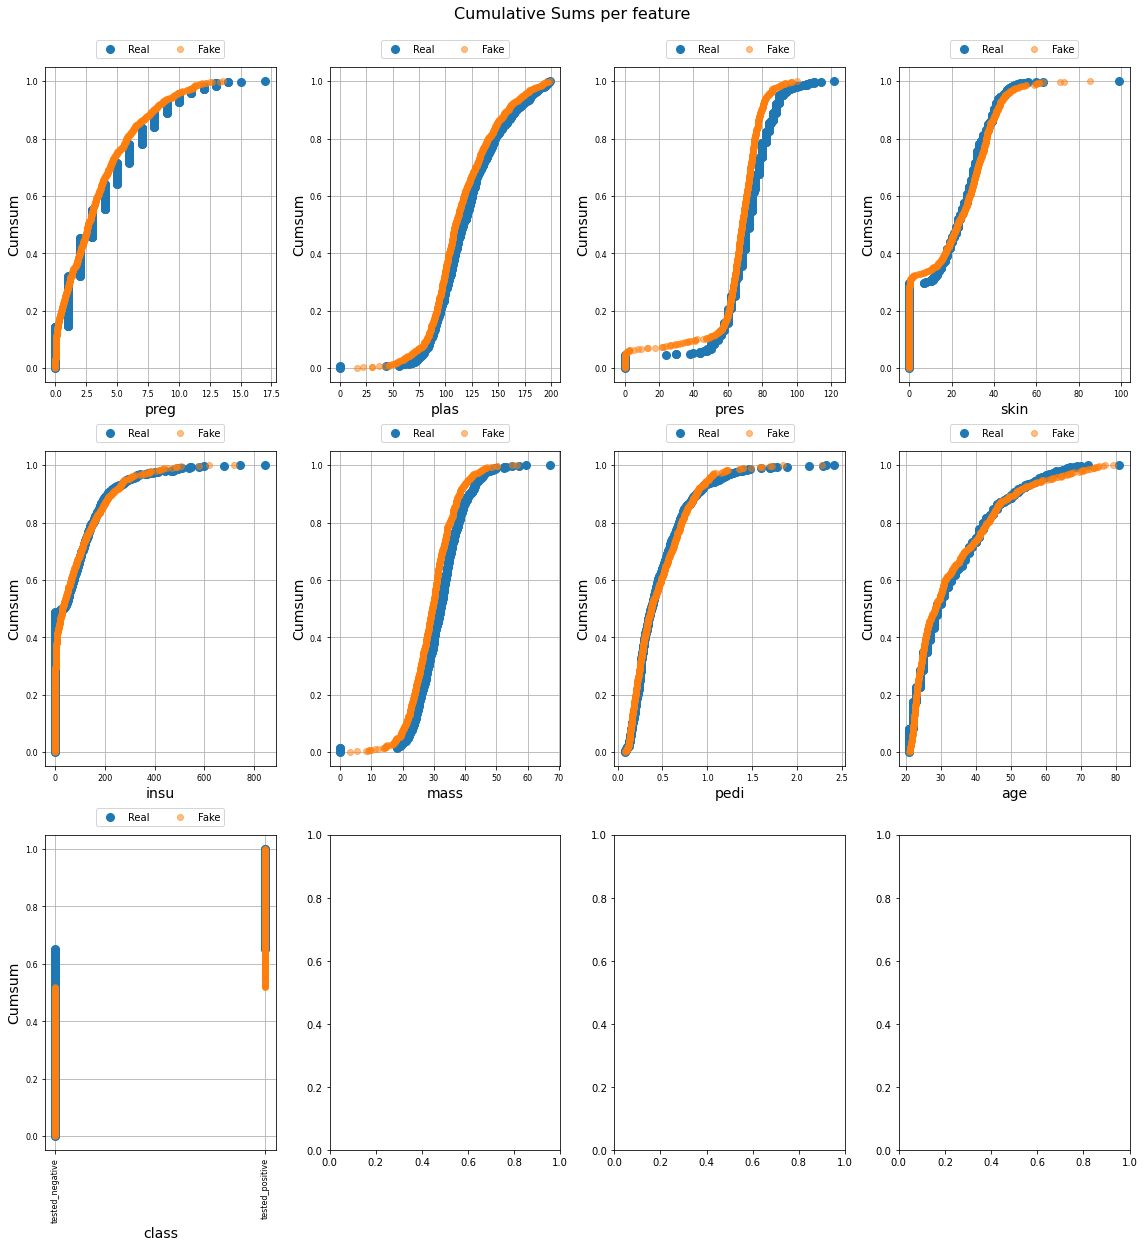

c:\Users\Leor\anaconda3\envs\ass_4\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
c:\Users\Leor\anaconda3\envs\ass_4\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
c:\Users\Leor\anaconda3\envs\ass_4\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].appen

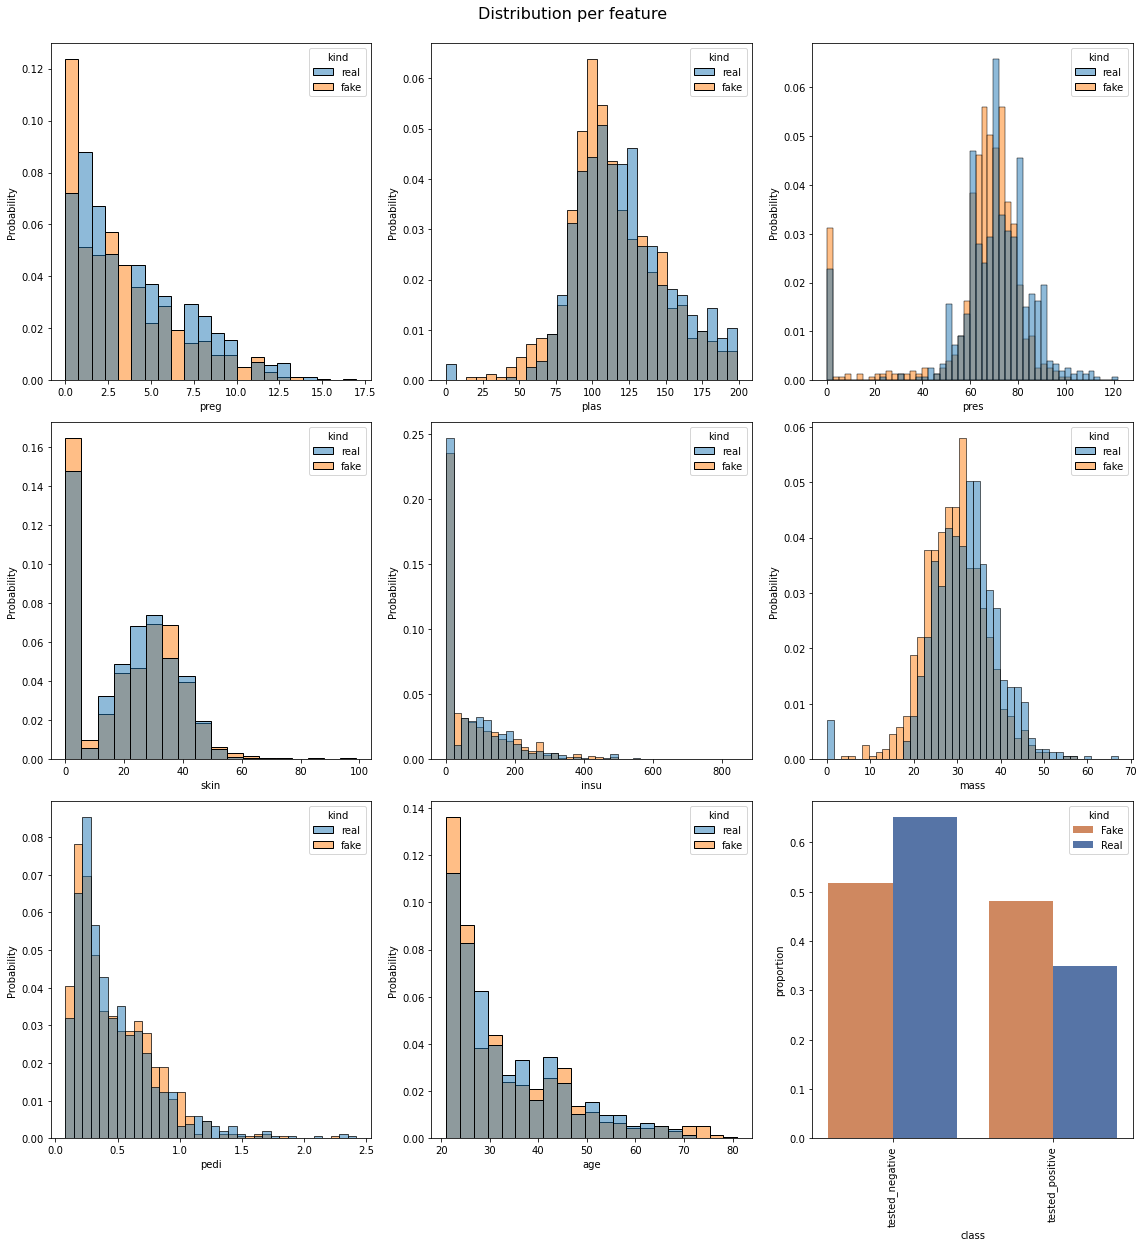

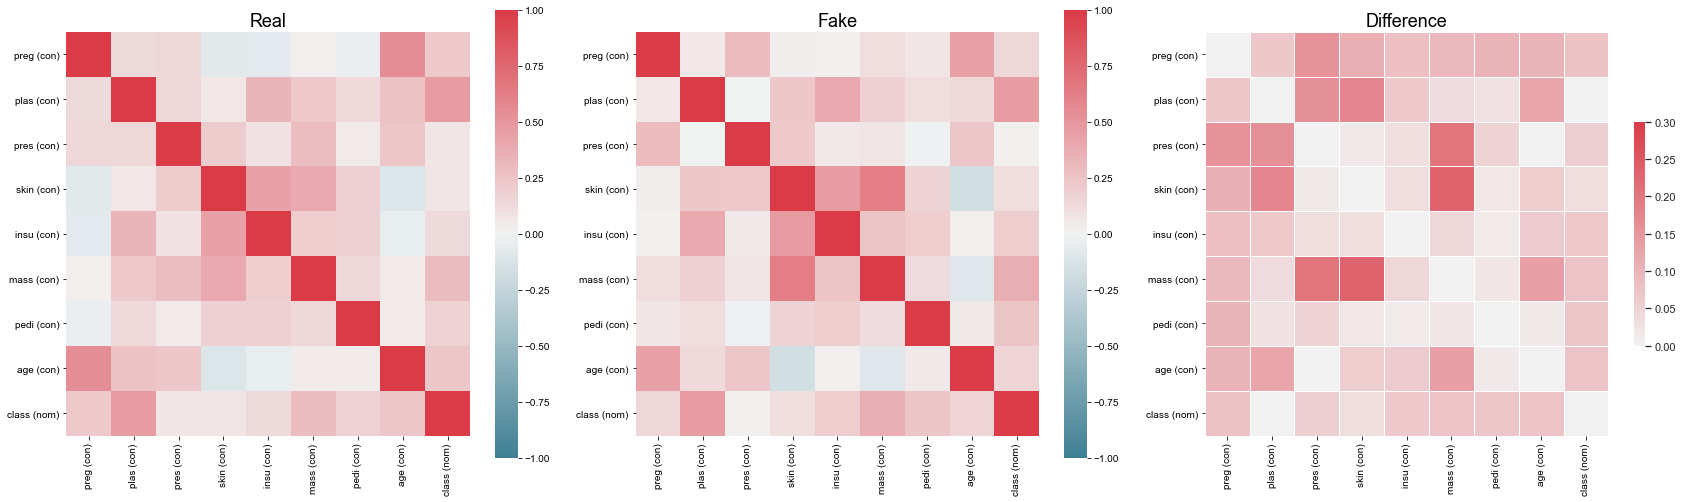

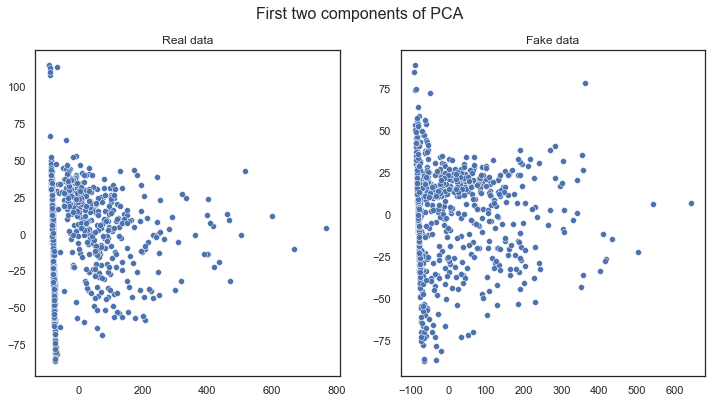

In [19]:
table_evaluator = TableEvaluator(diabetes_df, fake_diabetes_df, cat_cols=["class"])
table_evaluator.visual_evaluation()

In [20]:
table_evaluator.evaluate(target_col='class')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6039   0.7792              0.5172
DecisionTreeClassifier_real   0.7013   0.6039              0.4194
LogisticRegression_fake       0.6169   0.8052              0.4879
LogisticRegression_real       0.7662   0.6688              0.5172
MLPClassifier_fake            0.6364   0.7857              0.5477
MLPClassifier_real            0.7208   0.6883              0.6649
RandomForestClassifier_fake   0.6753   0.7922              0.6042
RandomForestClassifier_real   0.7922   0.6429              0.4737

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.3749
nearest neighbor std                     0.5269

Miscellaneous results:
                                  Result
Column Cor

Next, let's visualize the real and fake pca embeddings:

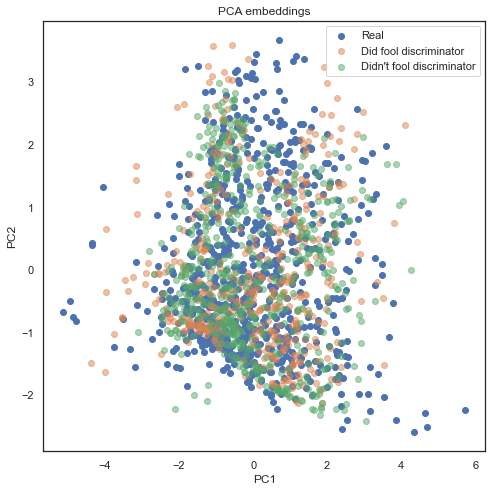

In [21]:
# Get embedding of fake and real data from pca
pca = PCA(n_components=2)
diabetes_low_X = pca.fit_transform(
    StandardScaler().fit_transform(diabetes_df.loc[:, "preg":"age"])
)
diabetes_fake_fooled_low_X = pca.transform(
    StandardScaler().fit_transform(fooled.loc[:, "preg":"age"])
)
diabetes_fake_not_fooled_low_X = pca.transform(
    StandardScaler().fit_transform(not_fooled.loc[:, "preg":"age"])
)

# Plot embeddings
plt.figure(figsize=(7, 7))
plt.scatter(diabetes_low_X[:, 0], diabetes_low_X[:, 1], label="Real")
plt.scatter(
    diabetes_fake_fooled_low_X[:, 0], diabetes_fake_fooled_low_X[:, 1],
    label="Did fool discriminator", alpha=0.5
)
plt.scatter(
    diabetes_fake_not_fooled_low_X[:, 0], diabetes_fake_not_fooled_low_X[:, 1],
    label="Didn't fool discriminator", alpha=0.5
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA embeddings")
plt.legend()
plt.tight_layout()
plt.show()


##### ***German Credit training & evaluation***

In [22]:
g_credit_df
["Status_of_existing_checking_account", "Duration_in_month"
"Credit_history", "Purpose", "Credit_amount", "Savings_account",
"Present_employment_since", "Installment_rate_in_percentage_of_disposable_income",
"Personal_status_and_sex", "Other debtors / guarantors", "Present residence since",
"Property", "Age in years", "Other installment plans", "Housing", "Number of existing credits at this bank", "Job",
"Number of people being liable to provide maintenance for", "Telephone", "foreign worker", "Class"]

NameError: name 'g_credit_df' is not defined